In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import learning_curve

warnings.filterwarnings("ignore")

print("All libraries loaded")

All libraries loaded


In [2]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
# print(data.head())
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [3]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 2})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
1    128
2     68
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo  

In [4]:
from sklearn.preprocessing import OneHotEncoder

X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (123, 21), Datos de validación: (53, 21), Datos de prueba ciega: (40, 21)


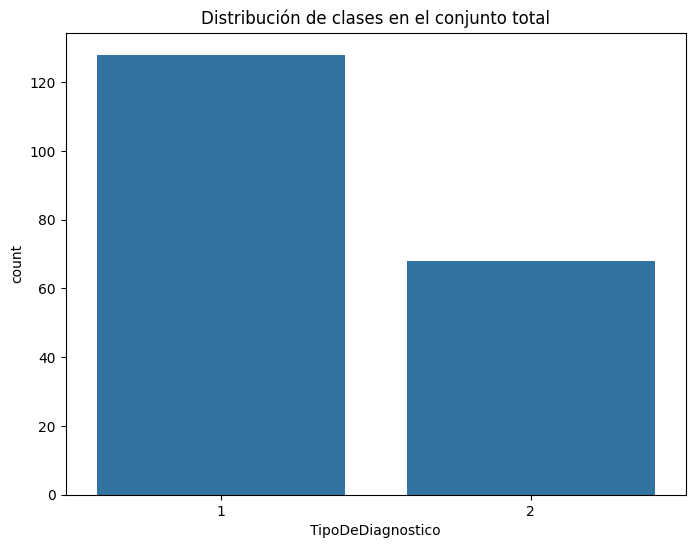

TipoDeDiagnostico
1    128
2     68
Name: count, dtype: int64


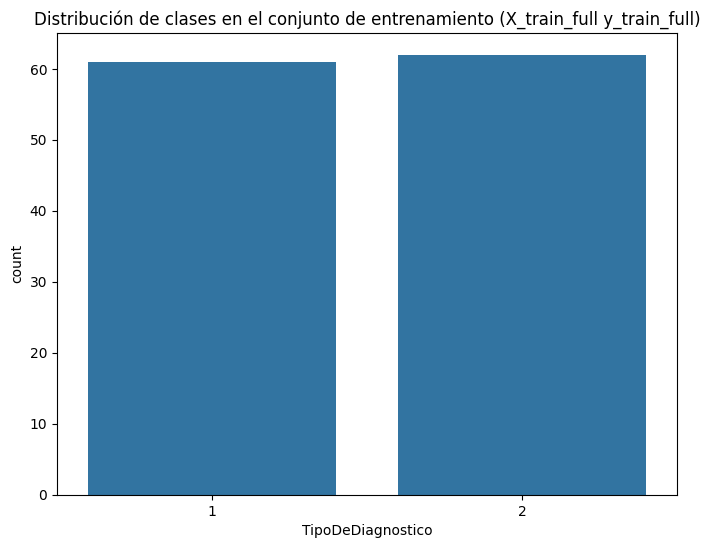

TipoDeDiagnostico
2    62
1    61
Name: count, dtype: int64


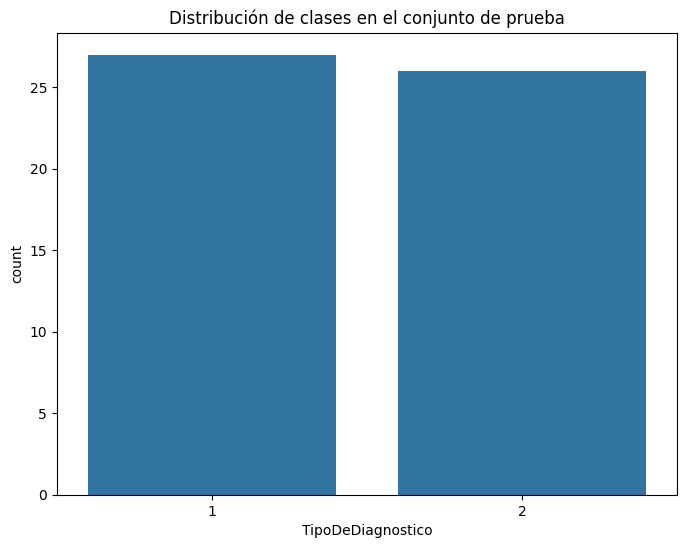

TipoDeDiagnostico
1    27
2    26
Name: count, dtype: int64


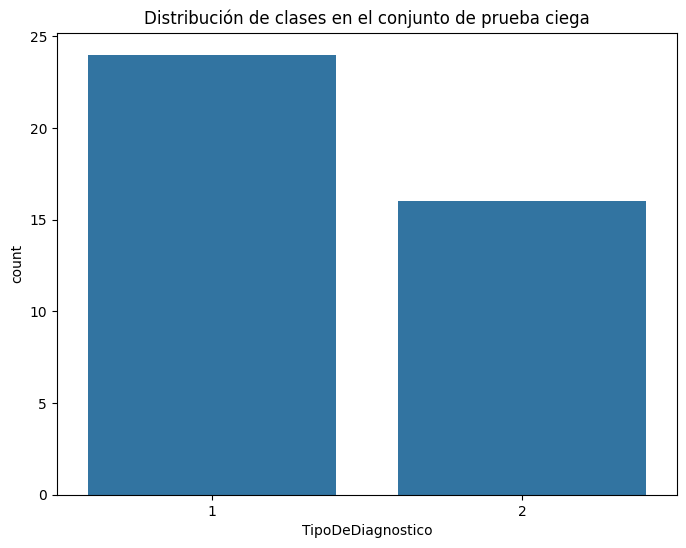

TipoDeDiagnostico
1    24
2    16
Name: count, dtype: int64


In [15]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

#Ampliacion de datos 
smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Divición de datos para entrenamiento
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba ciega')
plt.show()
print(y_test_blind.value_counts())

In [ ]:
param_grid = {
    'estimator__max_depth': [10, 15, 20, None],  
    'estimator__min_samples_split': [2, 4, 6],  
    'estimator__min_samples_leaf': [1, 2, 3], 
    'estimator__max_features': [None, 'sqrt', 'log2'], 
    'n_estimators': [100, 300, 500], 
    'max_samples': [0.75, 1.0],  
    'bootstrap': [True], 
    'bootstrap_features': [True], 
    'oob_score': [True],  
    'warm_start': [False]  
}

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)



bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [17]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = bagging, 
    param_distributions=param_grid, 
    n_iter=50, 
    cv=cv_strategy, 
    random_state=42, 
    n_jobs=-1,
    scoring='f1',
    verbose=2
)


In [18]:
random_search.fit(X_train_full, y_train_full)
print("Mejores hiperparámetros encontrados:", random_search.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados: {'warm_start': False, 'oob_score': True, 'n_estimators': 500, 'max_samples': 1.0, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'log2', 'estimator__max_depth': 10, 'bootstrap_features': True, 'bootstrap': True}


In [19]:
y_val_pred = random_search.predict(X_test_full)

print("Evaluación en el conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred))


Evaluación en el conjunto de validación:
Accuracy: 0.7736
Precision: 0.7748
Recall: 0.7736
F1 Score: 0.7731

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.76      0.81      0.79        27
           2       0.79      0.73      0.76        26

    accuracy                           0.77        53
   macro avg       0.78      0.77      0.77        53
weighted avg       0.77      0.77      0.77        53



In [10]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")


Evaluación en conjunto de prueba ciega:
Accuracy: 0.8000
Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000


In [11]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred, average='weighted'):.4f}")


Evaluación en conjunto train original:
Accuracy: 0.8333
Precision: 0.8310
Recall: 0.8333
F1 Score: 0.8316


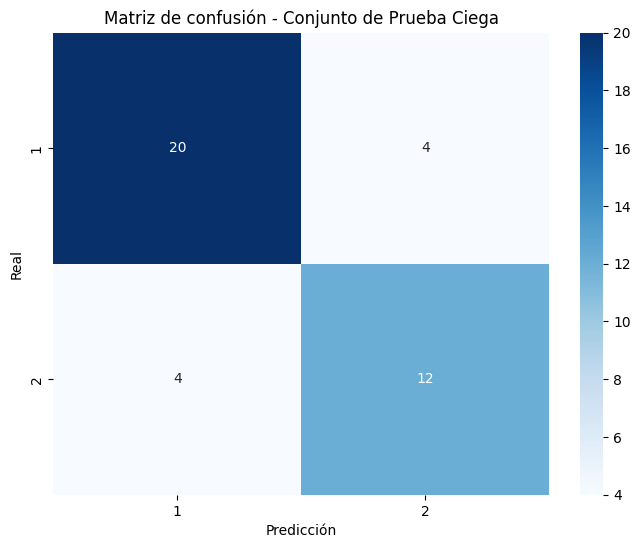

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


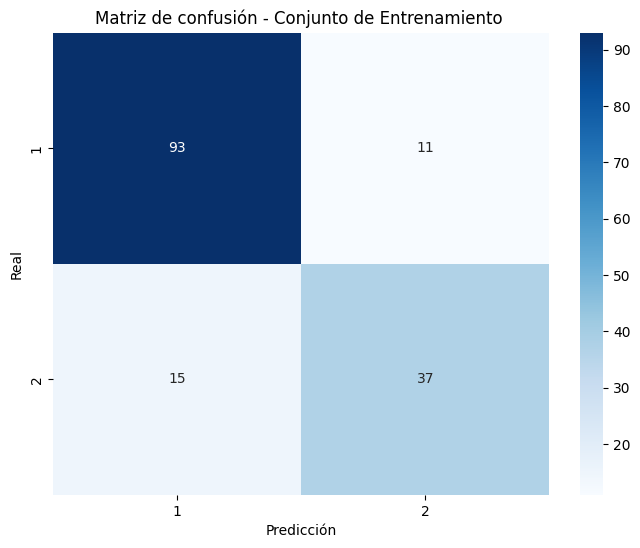

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


Características más importantes en BaggingClassifier:
Números detectados correctamente    0.073259
lowest_point_x                      0.069492
Total numeros detectados            0.066443
Números algo detectado              0.063589
Manecillas diferentes               0.060778
Manecilla 11 correcta               0.054711
puntuacion final                    0.049668
longitud_relativa_11pm              0.047308
lowest_point_y                      0.046197
Números con error espacial          0.044831
dtype: float64


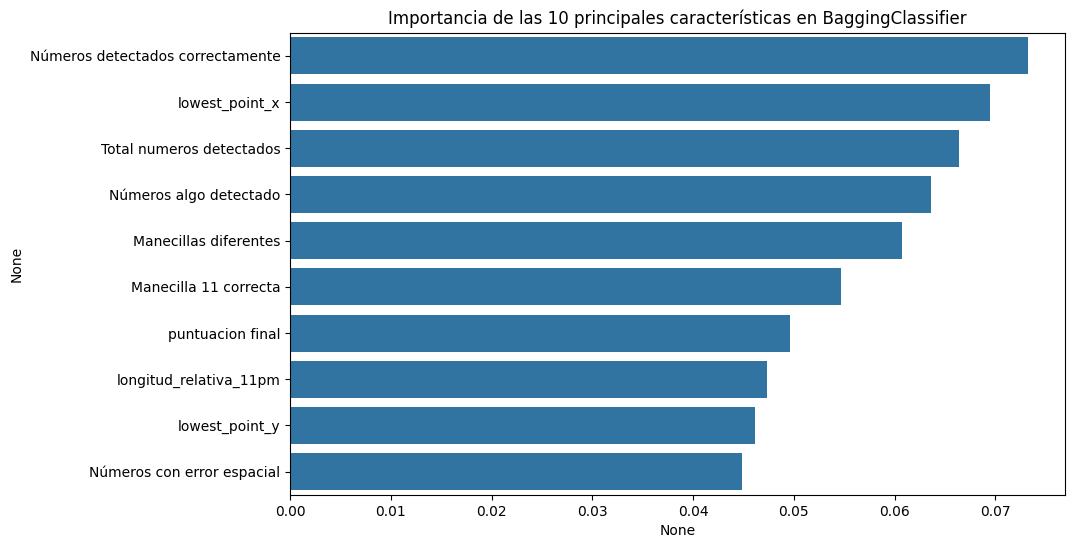

In [14]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()
